CIFAR10 dataset trained on all classes with resnet56 without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [19]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet56',
    "DS_INFO": 'complete',
    "resample": True,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 10,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [20]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

cat               : 5000
airplane          : 5000
deer              : 5000
automobile        : 5000
ship              : 5000
horse             : 5000
truck             : 5000
dog               : 5000
bird              : 5000
frog              : 5000

Total number of images: 50000, in 10 classes
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[6 8 1 3 7 7 2 5 2 4]
[5 2 3 7 9 2 2 0 7 9]
[4 6 1 1 5 6 9 5 2 3]
[4 9 9 0 6 1 1 7 2 8]
[9 5 8 7 4 6 3 8 4 4]
[8 6 1 4 0 3 0 2 7 2]
[6 7 6 0 1 9 5 4 0 6]
[7 8 0 5 7 2 4 4 5 0]
[9 4 0 5 4 4 2 9 1 2]
[4 1 1 5 4 5 4 4 4 5]


## Training

### Resnet56 (not pretrained)
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

In [21]:
import resnet
import datetime
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

NUM_GPUS = 1
BS_PER_GPU = 128
BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 3), (0.01, 6)]

In [22]:
PATH = os.getenv('PATH')
%env PATH=/home/henrik/anaconda3/envs/TF2/bin:$PATH

env: PATH=/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/henrik/.dotnet/tools


In [23]:
def schedule(epoch):
    initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
    learning_rate = initial_learning_rate
    for mult, start_epoch in LR_SCHEDULE:
        if epoch >= start_epoch:
            learning_rate = initial_learning_rate * mult
        else:
            break
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

Create and compile the model

In [24]:
img_input = tf.keras.layers.Input(shape=config["IMG_SIZE"])
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    resnet56_model = resnet.resnet56(img_input=img_input, classes=params["NUM_CLASSES"])
    resnet56_model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        resnet56_model = resnet.resnet56(img_input=img_input, classes=params["NUM_CLASSES"])
        resnet56_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

In [25]:
if config["verbosity"] > 0:
    resnet56_model.summary()

Model: "resnet56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
log_dir="logs/resnet56/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        update_freq='batch',
        histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)

Train the model

In [27]:
history = resnet56_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = [tensorboard_callback, lr_schedule_callback])

Train for 546 steps, validate for 117 steps
Epoch 1/10
546/546 [==============================] - 32s 59ms/step - loss: 2.9237 - sparse_categorical_accuracy: 0.2577 - val_loss: 4.2446 - val_sparse_categorical_accuracy: 0.1444
Epoch 2/10
546/546 [==============================] - 21s 39ms/step - loss: 2.1775 - sparse_categorical_accuracy: 0.4273 - val_loss: 3.4202 - val_sparse_categorical_accuracy: 0.2443
Epoch 3/10
546/546 [==============================] - 21s 39ms/step - loss: 1.7294 - sparse_categorical_accuracy: 0.5438 - val_loss: 2.3759 - val_sparse_categorical_accuracy: 0.3745
Epoch 4/10
546/546 [==============================] - 21s 39ms/step - loss: 1.3122 - sparse_categorical_accuracy: 0.6799 - val_loss: 1.6674 - val_sparse_categorical_accuracy: 0.5684
Epoch 5/10
546/546 [==============================] - 21s 39ms/step - loss: 1.1794 - sparse_categorical_accuracy: 0.7234 - val_loss: 1.3029 - val_sparse_categorical_accuracy: 0.6830
Epoch 6/10
546/546 [==========================

In [28]:
# resnet56_model.save('models/{}.h5'.format(model_name))
# resnet56_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [29]:
resnet56_evaluate = resnet56_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

117/117 - 1s - loss: 0.9065 - sparse_categorical_accuracy: 0.8165


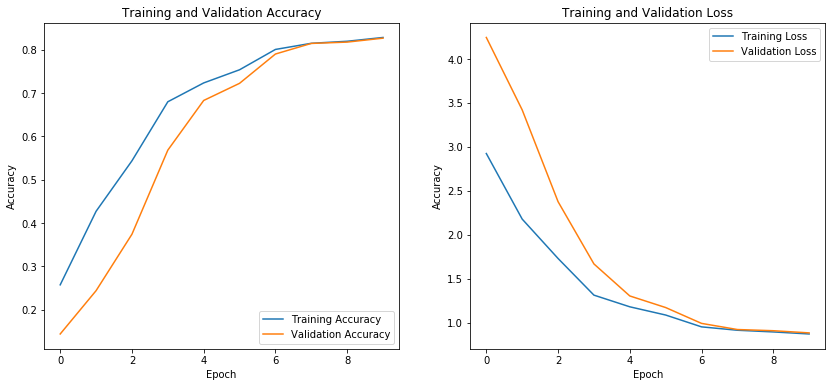

In [30]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

In [18]:
from tensorboard import notebook
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start tensorboard
%tensorboard --logdir logs

## Predict new samples

In [14]:
# Fetch one batch from validation dataset
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0132 cat
0.0592 airplane
0.0025 deer
0.0235 automobile
0.0035 ship
0.0371 horse
0.5859 truck
0.0094 dog
0.2631 bird
0.0027 frog

Label: truck
Predicton: truck


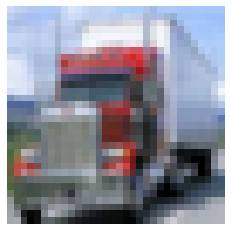

In [15]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet56_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [16]:
# Predict one batch
predictions = resnet56_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  ship        bird        Wrong
  1  ship        bird        Wrong
  2  truck       ship        Wrong
  3  frog        frog      
  4  dog         bird        Wrong
  5  ship        ship      
  6  deer        bird        Wrong
  7  bird        bird      
  8  frog        frog      
  9  frog        bird        Wrong
 10  cat         bird        Wrong
 11  dog         bird        Wrong
 12  horse       horse     
 13  horse       bird        Wrong
 14  automobile  automobile
 15  ship        ship      
 16  cat         horse       Wrong
 17  airplane    bird        Wrong
 18  bird        bird      
 19  ship        bird        Wrong
 20  dog         bird        Wrong
 21  airplane    airplane  
 22  deer        deer      
 23  horse       bird        Wrong
 24  ship        ship      
 25  bird        bird      
 26  horse       bird        Wrong
 27  deer        bird        Wrong
 28  dog         bird        Wrong
 29  frog        bir